In [1]:
import os
import sys
import csv
import wave
import copy
import math

import numpy as np
import pandas as pd

from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import StratifiedKFold, KFold, train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split,GridSearchCV
from sklearn.svm import OneClassSVM, SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.grid_search import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from keras.callbacks import EarlyStopping 
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import merge as Merge
from keras.layers import Masking, Embedding,Dropout
from keras.layers import LSTM, Input, Bidirectional,BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import SGD, Adam, RMSprop

sys.path.append("../")
from utilities.utils import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from IPython.display import clear_output

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


In [2]:
batch_size = 64
nb_feat = 34
nb_class = 4
nb_epoch =20
optimizer = 'Adadelta'

In [3]:
params = Constants()
params.path_to_features=r"C:\Users\yaolinli\Desktop\我爱学习-大三上\SpokenLanguage\emotion_recognition-master\data\features_new\total\\"
print(params)



----------------------------------------------------------------------------------------------------
available_emotions            ['baby' 'car' 'rain' 'sheep' 'siren']                                 
conf_matrix_prefix            iemocap                                                               
framerate                     16000                                                                 
path_to_data                  E:\IEMOCAP_full_release_withoutVideos\IEMOCAP_full_release\           
path_to_features              C:\Users\yaolinli\Desktop\我爱学习-大三上\SpokenLanguage\emotion_recognition-
path_to_txts                  C:\Users\yaolinli\Desktop\我爱学习-大三上\SpokenLanguage\emotion_recognition-
path_to_wavs                  C:\Users\yaolinli\Desktop\我爱学习-大三上\SpokenLanguage\emotion_recognition-
sessions                      ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']          
types                         {1: <class 'numpy.int8'>, 2: <class 'numpy.int16'>, 4: <class

# Calculating features

In [4]:
data = read_iemocap_data(params=params)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'E:\\IEMOCAP_full_release_withoutVideos\\IEMOCAP_full_release\\Session1/dialog/wav/'

In [5]:
get_features(data, params)

NameError: name 'data' is not defined

# Data preparation

In [7]:
X, y, valid_idxs = get_sample(ids=None, take_all=True,params= params)
print(X.shape)
y = to_categorical(y, params)
idxs_train, idxs_test = train_test_split(range(X.shape[0]), test_size=0.4)
X, _ = pad_sequence_into_array(X, maxlen=None,value = -1)
print(X.shape)
X_train, X_test = X[idxs_train], X[idxs_test]
#X_train_mask, X_test_mask = X_mask[idxs_train], X_mask[idxs_test]
y_train, y_test = y[idxs_train], y[idxs_test]
#y_train_mask, y_test_mask = y_mask[idxs_train], y_mask[idxs_test]
print(X_train.shape)

(200,)
(200, 278, 34)
(120, 278, 34)


# Model definition

In [58]:
batch_size = 64
nb_feat = 34
nb_class = 5
optimizer = 'Adadelta'
def build_simple_lstm(nb_feat, nb_class, optimizer='Adadelta'):
    model = Sequential()
    model.add(Masking(mask_value= -1,input_shape=(X_train.shape[1], nb_feat)))
    model.add(Bidirectional(LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], nb_feat))))#return_swquence 【】 改成true试试
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(nb_class))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [59]:
def build_blstm(nb_feat, nb_class, optimizer='Adadelta'):#nb_feat是输入维数，nb_class是输出的类别
    net_input = Input(shape=(278, nb_feat))
    forward_lstm1  = LSTM(output_dim=64, 
                          return_sequences=True, 
                          activation="tanh"
                         )(net_input)
    backward_lstm1 = LSTM(output_dim=64, 
                          return_sequences=True, 
                          activation="tanh", 
                          go_backwards=True
                         )(net_input)
    blstm_output1  = Merge(mode='concat')([forward_lstm1, backward_lstm1])
    
    forward_lstm2  = LSTM(output_dim=64, 
                          return_sequences=False, 
                          activation="tanh"
                         )(blstm_output1)
    backward_lstm2 = LSTM(output_dim=64, 
                          return_sequences=False, 
                          activation="tanh", 
                          go_backwards=True
                         )(blstm_output1)
    blstm_output2  = Merge(mode='concat')([forward_lstm2, backward_lstm2])
    hidden = Dense(256, activation='tanh')(blstm_output2)
    output = Dense(nb_class, activation='softmax')(hidden)
    model  = Model(net_input, output)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Model building

In [62]:
#model = build_model()
model=build_simple_lstm(34,5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_12 (Masking)         (None, 278, 34)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               166912    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 1285      
_________________________________________________________________
activation_12 (Activation)   (None, 5)                 0         
Total params: 169,221
Trainable params: 168,709
Non-trainable params: 512
_________________________________________________________________


# Training

In [63]:
nb_epoch = 20

early_stopping =EarlyStopping(monitor='val_loss', patience=8) 
hist = model.fit(X_train, y_train, 
                 batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, callbacks=[early_stopping],
                 validation_data=(X_test, y_test))

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 120 samples, validate on 80 samples
Epoch 1/20
120/120 [==============================] - 22s 182ms/step - loss: 1.7340 - acc: 0.3167 - val_loss: 1.3200 - val_acc: 0.4500
Epoch 2/20
120/120 [==============================] - 14s 117ms/step - loss: 1.6799 - acc: 0.4167 - val_loss: 1.2667 - val_acc: 0.4750
Epoch 3/20
120/120 [==============================] - 18s 146ms/step - loss: 1.5166 - acc: 0.4083 - val_loss: 1.3418 - val_acc: 0.4500
Epoch 4/20
120/120 [==============================] - 14s 113ms/step - loss: 1.4071 - acc: 0.4417 - val_loss: 1.1994 - val_acc: 0.5000
Epoch 5/20
120/120 [==============================] - 14s 115ms/step - loss: 1.2351 - acc: 0.4250 - val_loss: 1.1868 - val_acc: 0.4875
Epoch 6/20
120/120 [==============================] - 13s 110ms/step - loss: 1.3074 - acc: 0.4583 - val_loss: 1.4069 - val_acc: 0.4125
Epoch 7/20
120/120 [==============================] - 13s 112ms/step - loss: 1.1793 - acc: 0.5583 - val_loss: 1.0088 - val_acc: 0.5750
Epoch 8/20

# PRINT

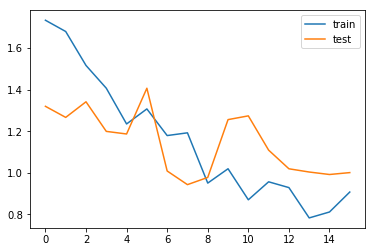

In [64]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

In [10]:
from keras.models import load_model
 


In [11]:
 model.save('model_4classes_双向lstm_256D_0.54_16epches_改进特征向量.h5')

NameError: name 'model' is not defined